In [1]:
%matplotlib inline 
import numpy as np 
import pylab as pl 
from wmf import wmf
import glob
import pandas as pd 
from string import Template

No se logra importar deap tools, por lo tanto se deshabilita SimuBasin.Calib_NSGAII


In [2]:
# reads the watershed 
cu = wmf.SimuBasin(rute='TurkeyBasin_simSetup.nc')
wmf.models.dt = 3600.
wmf.models.show_storage = 1

# reads rainfall 
year = '2002'
rain = wmf.read_rain_struct('stage4Rainfall/rain_'+year+'.hdr')
rain_bin = 'stage4Rainfall/rain_'+year+'.bin'
#rain = wmf.read_rain_struct('rain_'+year+'.hdr')
#rain_bin = 'rain_'+year+'.bin'


# reads the evaporation
et = pd.read_msgpack('MODIS_processed_et.msg')
et = et/10.

In [3]:
cu.GetGeo_Cell_Basics()

In [4]:
wmf.models.retorno_aq = 1
wmf.models.retorno_gr = 1

In [5]:
wmf.models.h_exp[-1] = 0.32
wmf.models.max_aquifer = wmf.models.max_gravita * 10

In [6]:
#Observed streamflow records
obs = {'05412500':{'link': 434514, 'mod_l': 20},
      '05412400':{'link': 399711, 'mod_l': 414},
      '05412020':{'link': 434478, 'mod_l': 712},
      '05411900':{'link': 418967, 'mod_l': 2778},
      '05411850':{'link': 434365, 'mod_l': 4447},
      '05411600':{'link': 483619, 'mod_l': 6273}}
Qobs = {}
for k in obs.keys():
    try:
        qo = pd.read_msgpack('/Users/nicolas/BaseData/USGS_hourly/'+str(obs[k]['link'])+'.msg')
        Qobs.update({str(obs[k]['mod_l']): qo})
    except:
        pass

In [14]:
# Sim period
f1 = year + '-04-01'
try:
    f1loc = rain.index.get_loc(f1).start
except:
    f1loc = rain.index.get_loc(f1)[0]

f2 = year + '-04-04'
try:
    f2loc = rain.index.get_loc(f2).stop
except:
    f2loc = rain.index.get_loc(f2)[-1]
Nsteps = f2loc - f1loc

In [43]:
save_dates=  pd.read_csv('rainyDay/EventsList.csv', index_col=0, parse_dates=True)
save_dates.sort_index(inplace=True)
save_dates = save_dates.index.intersection(rain.index[f1loc:f1loc+Nsteps])
save_dates = save_dates.unique()

In [44]:
# Initial conditions 
cu.set_Storage(90, 0)
cu.set_Storage(0.000001, 1)
cu.set_Storage(2.0, 2)
cu.set_Storage(35, 3)
cu.set_Storage(0.00001, 4)

In [45]:
%%time
#wmf.models.h_exp[3] = 0.15
Param = [0.000325, 2.0, 2.0, 0.0, 0.2, 0.00012, 0.01, 0.005, 1.0, 1.0, 1.0]

# Run the model
R = cu.run_shia(Param, rain_bin, Nsteps, f1loc,ruta_storage='ensayo.bin',
    EvpVariable = 'serie', 
    EvpSerie = et.values[f1loc:f2loc], 
    WheretoStore = save_dates)#pd.to_datetime(['2002-04-02 00:00','2002-04-03 00:00','2002-04-03 05:00']))

CPU times: user 16.2 s, sys: 140 ms, total: 16.4 s
Wall time: 16.8 s


In [59]:
# Sim period
year = '2016'
f1 = year + '-04-01'
f2 = year + '-11-30'
qs = pd.read_msgpack('outputs/streamflow/save'+year[-2:]+year+'.msg')
#qs = pd.read_msgpack('outputs/streamflow/save132013.msg')

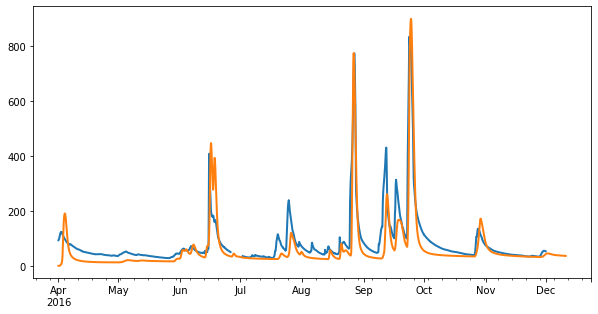

In [60]:
fig = pl.figure(figsize=(10,5))
Qobs['20'][f1:f2].plot.line(fig = fig, lw = 2, label = 'obs')
#R[1]['20'].plot.line(fig = fig, lw = 2, label = 'sim')
qs['20'].plot.line(fig = fig, lw = 2, label = 'sim')

#q2['20'].plot.line(fig = fig, lw = 2, label = 'sim2')
#q2.loc[R[1]['20'].index].plot()

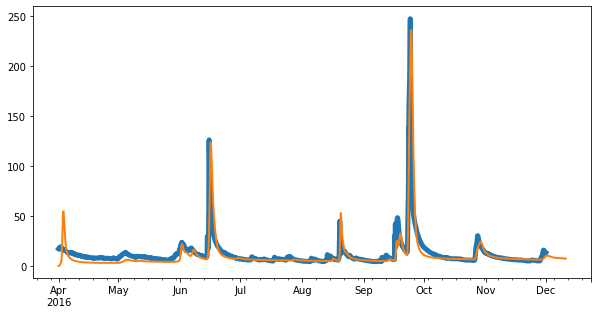

In [61]:
fig = pl.figure(figsize=(10,5))
Qobs['414'][f1:f2].plot.line(fig = fig, lw = 5, label = 'obs')
#R[1]['414'].plot.line(fig = fig, lw = 2, label = 'sim')
qs['414'].plot.line(fig = fig, lw = 2, label = 'sim')

#q2['414'].plot.line(fig = fig, lw = 2, label = 'sim2')

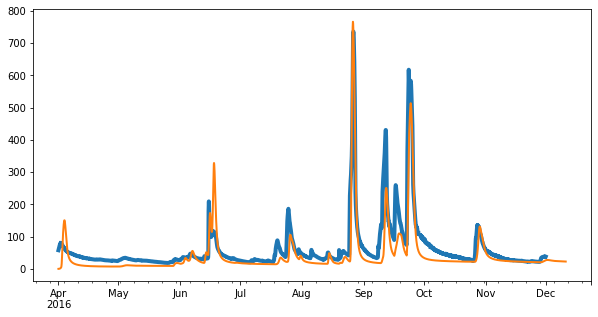

In [62]:
fig = pl.figure(figsize=(10,5))
Qobs['712'][f1:f2].plot.line(fig = fig, lw = 4, label = 'obs')
#R[1]['712'].plot.line(fig = fig, lw = 2, label = 'sim')
qs['712'].plot.line(fig = fig, lw = 2, label = 'sim')

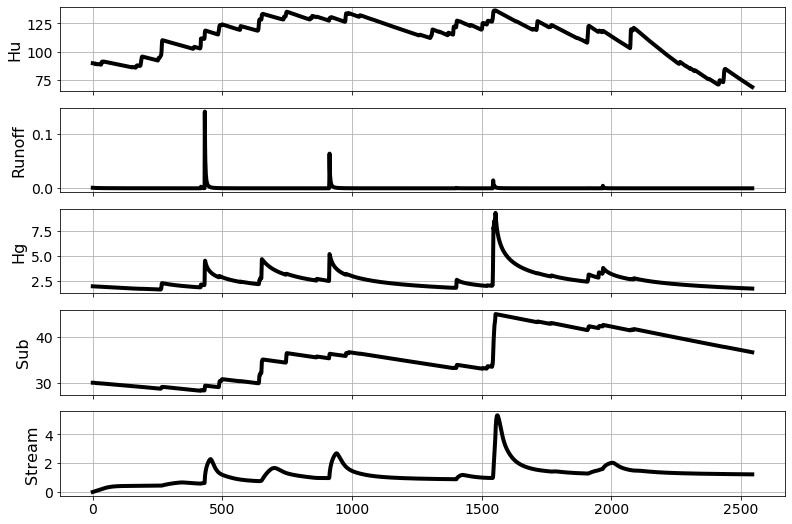

In [297]:
wmf.plot_mean_storage(R[0]['Mean_Storage'])